# Setting Up Enviroment

In [1]:
pip install sqlalchemy pyodbc pandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
#verifying driver
import pyodbc

drivers = pyodbc.drivers()
print("Installed ODBC Drivers:")
for driver in drivers:
    print(driver)

Installed ODBC Drivers:
SQL Server
SQL Server Native Client RDA 11.0
ODBC Driver 17 for SQL Server


In [3]:
import pyodbc
import pandas as pd
from sqlalchemy import create_engine
import sqlalchemy as sa

# Define your connection parameters
server = r'xxxxxx'
database = r'Pizza_Project'

# Create the connection string
connection_string = f'mssql+pyodbc://{server}/{database}?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server'

# Create an engine
engine = sa.create_engine(connection_string)

In [4]:
# Test the connection
try:
    with engine.connect() as conn:
        print("Connection successful")
except Exception as e:
    print("Error: ", e)

# Load data from SQL Server into pandas DataFrames
query_pizzas = "SELECT * FROM dbo.pizzas"
query_pizza_types = "SELECT * FROM dbo.pizza_types"
query_order_details = "SELECT * FROM dbo.order_details"
query_orders = "SELECT * FROM dbo.orders_id"

# Use pandas to read the SQL queries into DataFrames
pizzas_df = pd.read_sql_query(query_pizzas, engine)
pizza_types_df = pd.read_sql_query(query_pizza_types, engine)
order_details_df = pd.read_sql_query(query_order_details, engine)
orders_df = pd.read_sql_query(query_orders, engine)

# Display the first few rows of each DataFrame to verify the data
print("Pizzas DataFrame:")
print(pizzas_df.head())

print("\nPizza Types DataFrame:")
print(pizza_types_df.head())

print("\nOrder Details DataFrame:")
print(order_details_df.head())

print("\nOrders DataFrame:")
print(orders_df.head())

Connection successful
Pizzas DataFrame:
     pizza_id pizza_type_id size  price
0   bbq_ckn_s       bbq_ckn    S  12.75
1   bbq_ckn_m       bbq_ckn    M  16.75
2   bbq_ckn_l       bbq_ckn    L  20.75
3  cali_ckn_s      cali_ckn    S  12.75
4  cali_ckn_m      cali_ckn    M  16.75

Pizza Types DataFrame:
  pizza_type_id                          name category  \
0       bbq_ckn    The Barbecue Chicken Pizza  Chicken   
1      cali_ckn  The California Chicken Pizza  Chicken   
2   ckn_alfredo     The Chicken Alfredo Pizza  Chicken   
3     ckn_pesto       The Chicken Pesto Pizza  Chicken   
4    southw_ckn   The Southwest Chicken Pizza  Chicken   

                                         ingredients  
0  Barbecued Chicken, Red Peppers, Green Peppers,...  
1  Chicken, Artichoke, Spinach, Garlic, Jalapeno ...  
2  Chicken, Red Onions, Red Peppers, Mushrooms, A...  
3  Chicken, Tomatoes, Red Peppers, Spinach, Garli...  
4  Chicken, Tomatoes, Red Peppers, Red Onions, Ja...  

Order Details Da

# Performing EDA

In [5]:
# Merge DataFrames for EDA
order_details_extended_df = pd.merge(order_details_df, pizzas_df, on='pizza_id')
order_details_extended_df = pd.merge(order_details_extended_df, pizza_types_df, on='pizza_type_id')

# Ensure the 'date' column is merged correctly
order_details_extended_df = pd.merge(order_details_extended_df, orders_df[['order_id', 'date']], on='order_id')

# Display the columns to check if 'date' is included
print("Columns in order_details_extended_df:")
print(order_details_extended_df.columns)

# Convert 'date' column to datetime format
order_details_extended_df['date'] = pd.to_datetime(order_details_extended_df['date'])

Columns in order_details_extended_df:
Index(['order_details_id', 'order_id', 'pizza_id', 'quantity', 'pizza_type_id',
       'size', 'price', 'name', 'category', 'ingredients', 'date'],
      dtype='object')


### Analysis

In [6]:
# Retrieve the total number of orders placed
total_orders = orders_df['order_id'].nunique()
print("Total number of orders placed:", total_orders)

Total number of orders placed: 21338


In [7]:
# Calculate the total revenue generated from pizza sales
total_revenue = (order_details_extended_df['quantity'] * order_details_extended_df['price']).sum()
print("Total revenue generated from pizza sales:", total_revenue)

Total revenue generated from pizza sales: 818073.8508396149


In [8]:
# Identify the highest-priced pizza
highest_priced_pizza = pizzas_df.loc[pizzas_df['price'].idxmax()]
print("Highest-priced pizza:", highest_priced_pizza)

Highest-priced pizza: pizza_id         the_greek_xxl
pizza_type_id        the_greek
size                       XXL
price                35.950001
Name: 43, dtype: object


In [9]:
# Identify the most common pizza size ordered
most_common_pizza_size = order_details_extended_df['size'].mode()[0]
print("Most common pizza size ordered:", most_common_pizza_size)

Most common pizza size ordered: L


In [10]:
# List the top 5 most ordered pizza types along with their quantities
top_5_pizza_types = order_details_extended_df.groupby('name')['quantity'].sum().nlargest(5)
print("Top 5 most ordered pizza types along with their quantities:")
print(top_5_pizza_types)

Top 5 most ordered pizza types along with their quantities:
name
The Classic Deluxe Pizza        2453
The Barbecue Chicken Pizza      2433
The Hawaiian Pizza              2422
The Pepperoni Pizza             2417
The California Chicken Pizza    2373
Name: quantity, dtype: int64


In [11]:
# Find the total quantity of each pizza category ordered
category_quantity = order_details_extended_df.groupby('category')['quantity'].sum()
print("Total quantity of each pizza category ordered:")
print(category_quantity)

Total quantity of each pizza category ordered:
category
Chicken    11059
Classic    14884
Supreme    11992
Veggie     11653
Name: quantity, dtype: int64


In [12]:
# Determine the distribution of orders by hour of the day
orders_df['hour'] = orders_df['time'].apply(lambda x: x.hour)
orders_by_hour = orders_df['hour'].value_counts().sort_index()
print("Distribution of orders by hour of the day:")
print(orders_by_hour)

Distribution of orders by hour of the day:
hour
9        1
10       8
11    1231
12    2520
13    2455
14    1472
15    1468
16    1920
17    2336
18    2399
19    2009
20    1642
21    1198
22     663
23      28
Name: count, dtype: int64


In [13]:
# Find the category-wise distribution of pizzas
category_distribution = order_details_extended_df['category'].value_counts()
print("Category-wise distribution of pizzas:")
print(category_distribution)

Category-wise distribution of pizzas:
category
Classic    14575
Supreme    11781
Veggie     11453
Chicken    10824
Name: count, dtype: int64


In [14]:
# Group the orders by date and calculate the average number of pizzas ordered per day
avg_pizzas_per_day = order_details_extended_df.groupby(order_details_extended_df['date'].dt.date)['quantity'].mean()
print("Average number of pizzas ordered per day:")
print(avg_pizzas_per_day)

Average number of pizzas ordered per day:
date
2023-01-01    1.006211
2023-01-02    1.031250
2023-01-03    1.025974
2023-01-04    1.000000
2023-01-05    1.033058
                ...   
2023-12-27    1.022989
2023-12-28    1.000000
2023-12-29    1.038961
2023-12-30    1.123288
2023-12-31    1.040936
Name: quantity, Length: 358, dtype: float64


In [15]:
# Determine the top 3 most ordered pizza types based on revenue
order_details_extended_df['revenue'] = order_details_extended_df['quantity'] * order_details_extended_df['price']
top_3_pizza_types_revenue = order_details_extended_df.groupby('name')['revenue'].sum().nlargest(3)
print("Top 3 most ordered pizza types based on revenue:")
print(top_3_pizza_types_revenue)

Top 3 most ordered pizza types based on revenue:
name
The Thai Chicken Pizza          43463.75
The Barbecue Chicken Pizza      42784.75
The California Chicken Pizza    41443.75
Name: revenue, dtype: float64


In [16]:
# Calculate the percentage contribution of each pizza type to total revenue
total_revenue = order_details_extended_df['revenue'].sum()
pizza_type_revenue_percentage = (order_details_extended_df.groupby('name')['revenue'].sum() / total_revenue) * 100
print("Percentage contribution of each pizza type to total revenue:")
print(pizza_type_revenue_percentage)

Percentage contribution of each pizza type to total revenue:
name
The Barbecue Chicken Pizza                    5.229937
The Big Meat Pizza                            2.807570
The Brie Carre Pizza                          1.413668
The Calabrese Pizza                           1.950252
The California Chicken Pizza                  5.066016
The Chicken Alfredo Pizza                     2.066348
The Chicken Pesto Pizza                       2.045200
The Classic Deluxe Pizza                      4.667121
The Five Cheese Pizza                         3.186326
The Four Cheese Pizza                         3.946300
The Greek Pizza                               3.473721
The Green Garden Pizza                        1.707395
The Hawaiian Pizza                            3.944693
The Italian Capocollo Pizza                   3.064943
The Italian Supreme Pizza                     4.092632
The Italian Vegetables Pizza                  1.957678
The Mediterranean Pizza                       1.881065

In [17]:
# Analyze the cumulative revenue generated over time
cumulative_revenue = order_details_extended_df.groupby(order_details_extended_df['date'].dt.date)['revenue'].sum().cumsum()
print("Cumulative revenue generated over time:")
print(cumulative_revenue)

Cumulative revenue generated over time:
date
2023-01-01      2713.850002
2023-01-02      5445.750004
2023-01-03      8108.150007
2023-01-04      9863.600008
2023-01-05     11929.550009
                  ...      
2023-12-27    810829.600828
2023-12-28    812466.800831
2023-12-29    813820.050833
2023-12-30    815157.850836
2023-12-31    818073.850840
Name: revenue, Length: 358, dtype: float64


In [18]:
# Determine the top 3 most ordered pizza types based on revenue for each pizza category
top_3_pizza_types_by_category = order_details_extended_df.groupby(['category', 'name'])['revenue'].sum().groupby(level=0, group_keys=False).nlargest(3)
print("Top 3 most ordered pizza types based on revenue for each pizza category:")
print(top_3_pizza_types_by_category)

Top 3 most ordered pizza types based on revenue for each pizza category:
category  name                        
Chicken   The Thai Chicken Pizza          43463.750000
          The Barbecue Chicken Pizza      42784.750000
          The California Chicken Pizza    41443.750000
Classic   The Classic Deluxe Pizza        38180.500000
          The Hawaiian Pizza              32270.500000
          The Pepperoni Pizza             30149.250000
Supreme   The Spicy Italian Pizza         34889.250000
          The Italian Supreme Pizza       33480.750000
          The Sicilian Pizza              30940.500000
Veggie    The Four Cheese Pizza           32283.651005
          The Mexicana Pizza              26764.750000
          The Five Cheese Pizza           26066.500000
Name: revenue, dtype: float64


# Visualization

In [19]:
pip install matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\Administrator\AppData\Local\Temp\ipykernel_10596\1453751428.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='quantity', y='name', data=top_pizza_types, palette='magma')


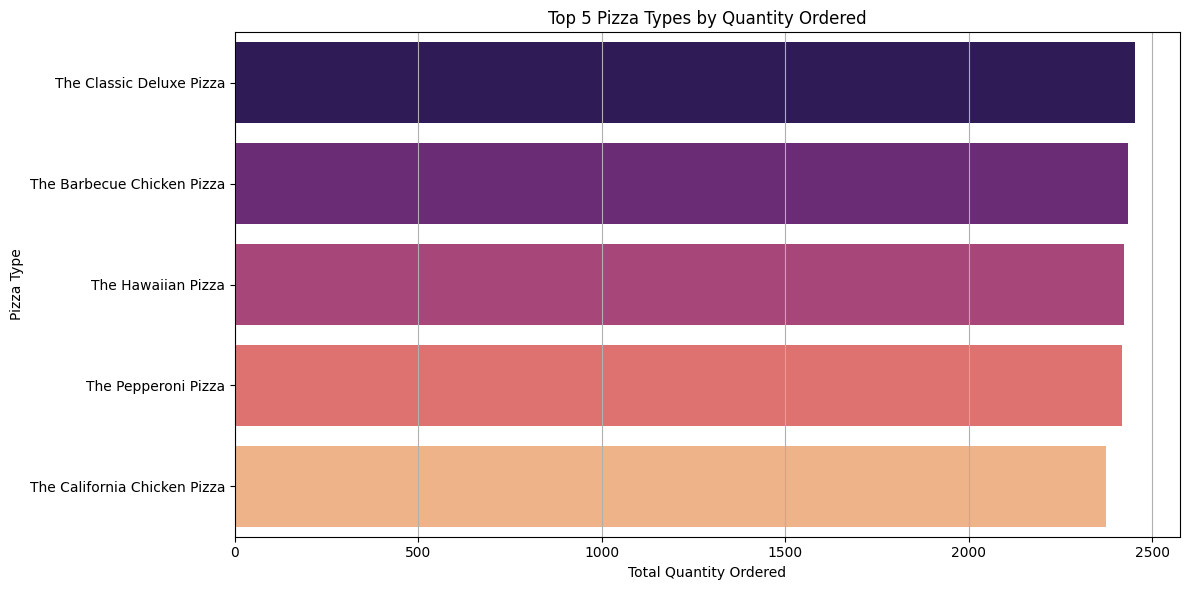

In [25]:
# Top Pizza Types by Quantity Ordered
top_pizza_types = order_details_extended_df.groupby('name')['quantity'].sum().nlargest(5).reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='quantity', y='name', data=top_pizza_types, palette='magma')
plt.title('Top 5 Pizza Types by Quantity Ordered')
plt.xlabel('Total Quantity Ordered')
plt.ylabel('Pizza Type')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

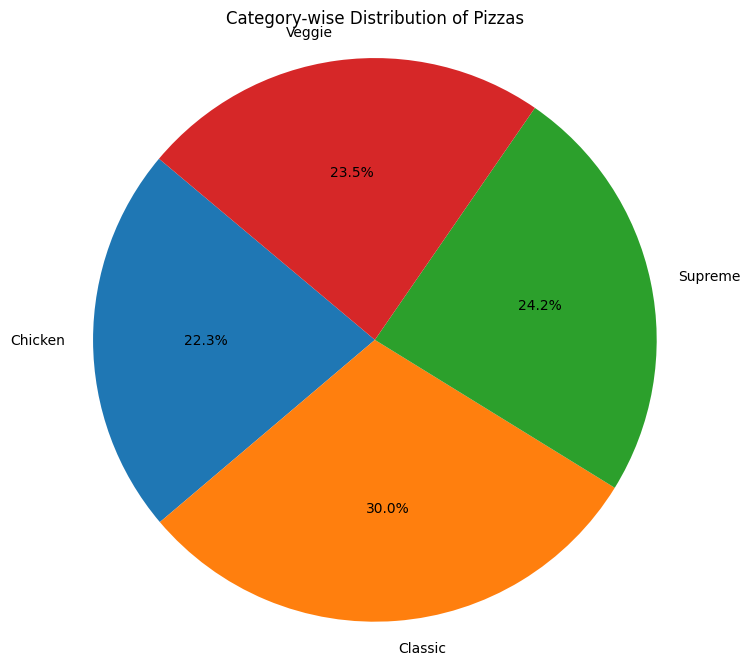

In [26]:
# Category-wise Distribution of Pizzas
category_distribution = order_details_extended_df.groupby('category')['quantity'].sum().reset_index()

plt.figure(figsize=(8, 8))
plt.pie(category_distribution['quantity'], labels=category_distribution['category'], autopct='%1.1f%%', startangle=140)
plt.title('Category-wise Distribution of Pizzas')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()